In [1]:
import nltk                                  # Python library for NLP
from nltk.corpus import twitter_samples      # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt              # visualization library
import numpy as np    

In [2]:
# downloads sample twitter dataset.
nltk.download('twitter_samples')
     

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [3]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 

# download the stopwords for the process_tweet function
nltk.download('stopwords')

import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets
     

In [5]:
# make a numpy array representing labels of the tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))
     

In [6]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg
     

In [8]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [9]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))
     

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [12]:
def process_tweet(tweet):
   
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'$\w*', '', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean
     

In [13]:
def build_freqs(tweets, ys):
    
    # tweets: a list of tweets
    # ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
   
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    
    # freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    
    return freqs              
     

In [14]:
# create frequency dictionary
freqs = build_freqs(tweets, labels)

# check data type
print(f'type(freqs) = {type(freqs)}')

# check length of the dictionary
print(f'len(freqs) = {len(freqs)}')
     

type(freqs) = <class 'dict'>
len(freqs) = 13066


In [15]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific']

# each element consist of a sublist with this pattern: [, , ]
data = []

# loop through our selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data
     

[['happi', 211, 25],
 ['merri', 1, 0],
 ['nice', 98, 19],
 ['good', 238, 101],
 ['bad', 18, 73],
 ['sad', 5, 123],
 ['mad', 4, 11],
 ['best', 65, 22],
 ['pretti', 20, 15],
 ['❤', 29, 21],
 [':)', 3568, 2],
 [':(', 1, 4571],
 ['😒', 1, 3],
 ['😬', 0, 2],
 ['😄', 5, 1],
 ['😍', 2, 1],
 ['♛', 0, 210],
 ['song', 22, 27],
 ['idea', 26, 10],
 ['power', 7, 6],
 ['play', 46, 48],
 ['magnific', 2, 0]]

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0, flags=flags)


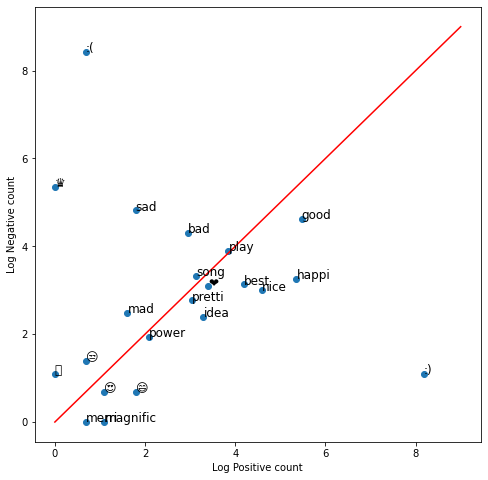

In [16]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red')  # Plot the red line that divides the 2 areas.
plt.show()
     

In [17]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

     

type(freqs) = <class 'dict'>
len(freqs) = 11337


In [18]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


Part -1 : Logistic Regression

In [19]:
def sigmoid(z): 

    h = 1/(1+np.exp(-z))
   
    return h
     

In [20]:
def gradientDescent(x, y, theta, alpha, num_iters):
   
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -(np.dot(y.T,np.log(h))+np.dot((1-y).T,np.log(1-h)))/m

        # update the weights theta
        theta = theta - alpha*(np.dot(x.T,h-y))/m
        
    J = float(J)
    return J, theta
     

Part-2 : Extracting the features

In [21]:
def extract_features(tweet, freqs):
    
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
       
    # loop through each word in the list of words
    for word in word_l:
         
        if (word,1.0) in freqs:
            # increment the word count for the positive label 1
            x[0,1] += freqs[(word,1.0)]
        if(word,0.0) in freqs:
            # increment the word count for the negative label 0
            x[0,2] += freqs[(word,0.0)]
        
    return x
     

Part - 3 : Training your model

In [22]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

print(X.shape)
print(Y.shape)
     

(8000, 3)
(8000, 1)


In [23]:
# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)

print(f"The cost after training is {J:.6f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.242155.
The resulting vector of weights is [7e-08, 0.00052391, -0.00055517]


Part - 4 : Visualising the Tweets 

Text(0, 0.5, 'Negative')

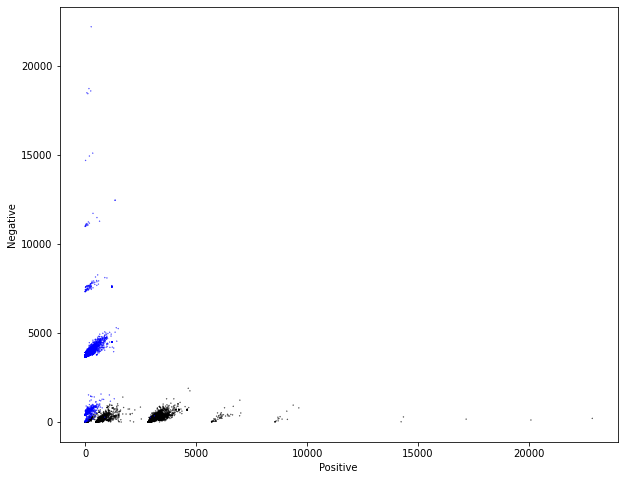

In [25]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (10, 8))

colors = ['blue', 'black']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

In [26]:
# Equation for the separation plane
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]
     


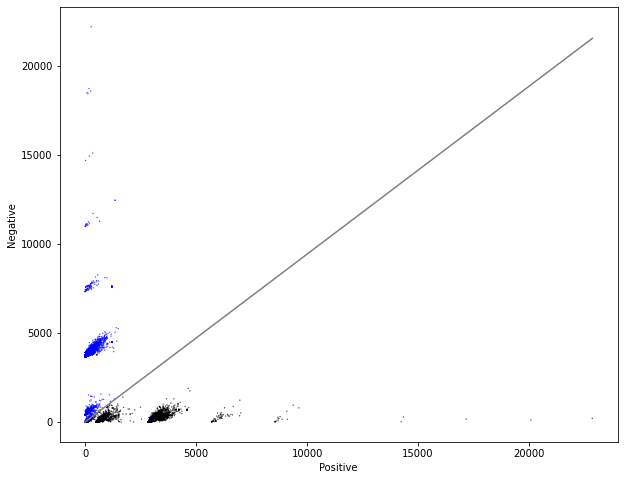

In [28]:
fig, ax = plt.subplots(figsize = (10, 8))

colors = ['blue', 'black']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])           # max value in x-axis

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

plt.show()
     

Part - 5 : Test your Logistic Regression

In [29]:
def predict_tweet(tweet, freqs, theta):

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    
    return y_pred
     

In [30]:
# check your own sentiment
my_tweet = 'I love machine learning :)'
y_pred_temp = predict_tweet(my_tweet, freqs, theta)
print(y_pred_temp)

if y_pred_temp > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

[[0.83158619]]
Positive sentiment


In [31]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """ 
    test_x: a list of tweets
    test_y: (m, 1) vector with the corresponding labels for the list of tweets
    """
    
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)

    accuracy = np.sum(np.squeeze(test_y) == np.squeeze(np.asarray(y_hat)))/len(test_y)

    return accuracy
     

In [32]:
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))
     

Label Predicted Tweet
THE TWEET IS: @jaredNOTsubway @iluvmariah @Bravotv Then that truly is a LATERAL move! Now, we all know the Queen Bee is UPWARD BOUND : ) #MovingOnUp
THE PROCESSED TWEET IS: ['truli', 'later', 'move', 'know', 'queen', 'bee', 'upward', 'bound', 'movingonup']
1	0.49996926	b'truli later move know queen bee upward bound movingonup'
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48636105	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48370709	b"i'm play brain dot braindot"
THE TWEET IS: I'm p